# Evaluate GTSDB extracted signs with GTSRB trained CNN

Subimages were extracted from the full image using the calculated masks, with extra padding added to account for the basic padding in the GTSRB dataset (10% with a min of 5 pixels is what is stated for the dataset). A few types of padding were tried (flat values, using 10% metric, none), with a flat addition of 7 performing the best. 

Ultimately, the best performing combination for everything was no image normaliztion on either set and using sign subcategories to make the masks. When not using sign subcategories, the pipeline preferred image normalization on the GTSDB Mask RCNN but not for the GTSRB CNN due to its ability to significantly reduce false bounding boxes. 

The final model has a 93% sign identification rate (finds signs it was supposed to), a 98.8% classification rate of those signs found, for 92% true sign recognition (correctly found the sign and properly classified it among 43 sign types) with a 0.5 false signs per image rate.  

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
import glob
from sklearn import metrics
from tensorflow.keras import utils

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras import utils

from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

## Data Prep

Extract the images and mold them into the same setup as the original GTSRB CNN. Use Iou > 0.4 to compare whether or not a box was correctly found. First pull the image bounding box from the GTSDB test set Mask RCNN, and evaluate overlap with actual boxes and categories. Eventually pull out subimages, using the bounding box with some padding 

In [63]:
image_size = 40

In [64]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [65]:
#Load in the masks
roi_df = pd.read_csv(f'../FullIJCNN2013/preds/box_list_sub_norm.txt',names=['file','x1','y1','x2','y2'],delimiter = ';')
label_df = pd.read_csv(f'../FullIJCNN2013/gt.txt',names=['file','x1','y1','x2','y2','class'],delimiter = ';')

In [66]:
#make a file_num column from name
roi_df['file_num'] = roi_df['file'].map(lambda x: int(x[:5]))
label_df['file_num'] = label_df['file'].map(lambda x: int(x[:5]))

In [67]:
bbox_adjust = pd.DataFrame()
#loop through test images
for i in range(600,900): 
    #get truth and roi ones
    temp_test = label_df[label_df['file_num']==i]
    temp_roi = roi_df[roi_df['file_num']==i]
    for j in range(temp_test.shape[0]):
        #truth box
        box1 = [temp_test.iloc[j,1],temp_test.iloc[j,2],temp_test.iloc[j,3],temp_test.iloc[j,4]]
        box_found = 0
        for k in range(temp_roi.shape[0]):
            #pred box
            box2 = [temp_roi.iloc[k,1],temp_roi.iloc[k,2],temp_roi.iloc[k,3],temp_roi.iloc[k,4]]
            iou = bb_intersection_over_union(box1,box2)
            #if found, save the difference in dimensions
            if iou>0.4:
                box_found = 1
                bbox_adjust = pd.concat([bbox_adjust,pd.DataFrame({'x1_diff':[temp_test.iloc[j,1] - temp_roi.iloc[k,1]],
                                                               'y1_diff':[temp_test.iloc[j,2] - temp_roi.iloc[k,2]],
                                                               'x2_diff':[temp_test.iloc[j,3] - temp_roi.iloc[k,3]],
                                                               'y2_diff':[temp_test.iloc[j,4] - temp_roi.iloc[k,4]]
                                                              })]) 
bbox_adjust.shape

(331, 4)

Check the box size between the two for fun

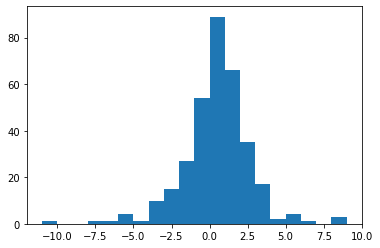

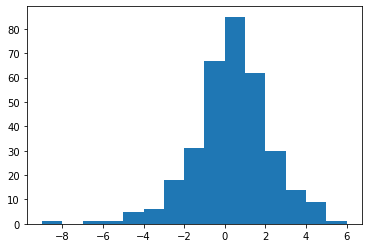

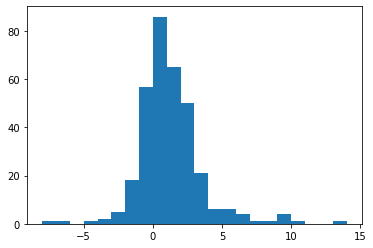

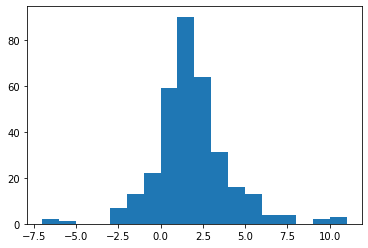

In [68]:
for col in bbox_adjust.columns:
    plt.hist(bbox_adjust[col],bins=bbox_adjust[col].max()-bbox_adjust[col].min());
    plt.show()

In [69]:
#load cnn model
cnn = load_model('../models/40_256_5_2_128_0.4_3_512_bg')

Here is where sumimages are extracted. Buffer is the added padding for the image. A buffer = 7 performed the best, chosen just to be a little bigger than the minimum of 5, and a few others tried. 

In [71]:
roi_images = []
roi_info = []
#loop over test images
for i in range(600,900):
    #load the image
    image_id = str(i).rjust(5,'0')
    image = cv2.imread(f'FullIJCNN2013/{image_id}.ppm')
#         image = cv2.resize(image, (image_size, image_size))
    #just that images info
    temp_df = roi_df[roi_df['file'] == image_id+'.ppm']
    for i in range(temp_df.shape[0]):
        #extract box
        box = [temp_df.iloc[i,1],temp_df.iloc[i,2],temp_df.iloc[i,3],temp_df.iloc[i,4]]
        #need to try and match padding from fit
        buffer = 7 #int(max(max(box[3]-box[1],box[2]-box[0])*0.1,5))
        
        roi_images.append(image[max(0,box[1]-buffer):min(799,box[3]+buffer),  
                                max(0,box[0]-buffer):min(1359,box[2]+buffer)])
len(roi_images)
    

565

Resize the image accordingly, and scale

In [72]:
#resize all
for i in range(len(roi_images)):
    roi_images[i] = cv2.resize(roi_images[i], (image_size, image_size))
#scale
roi_images = [image/255 for image in roi_images]
#convert
roi_images = np.array(roi_images)

## Predictions

Make the predictions, and look at some of the results. 

In [73]:
preds = cnn.predict(roi_images).round(0)

In [76]:
#load sign demo images
signs = []
for i in range(43):
    signs.append(cv2.cvtColor(cv2.imread(f'GTSRB/tsr-analysis-src/resources/signs/{i}.jpg'),cv2.COLOR_BGR2RGB))

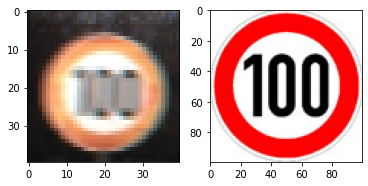

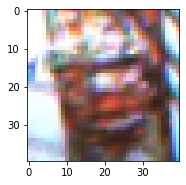

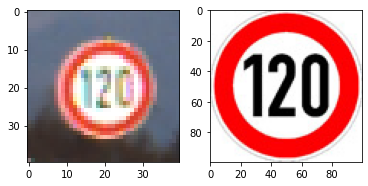

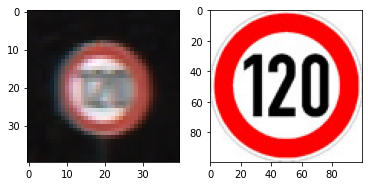

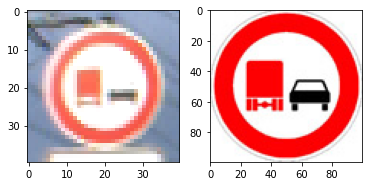

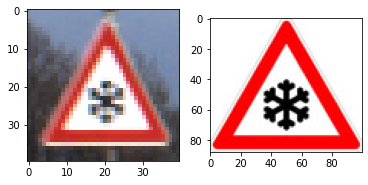

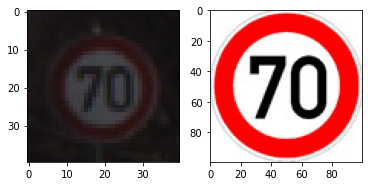

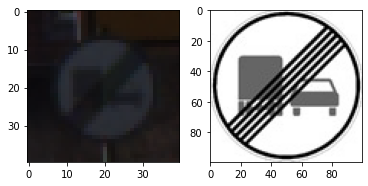

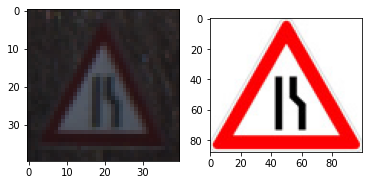

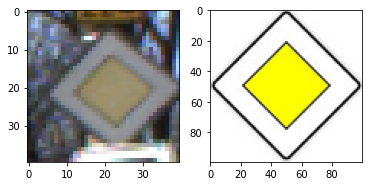

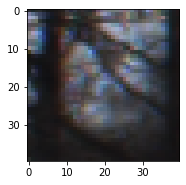

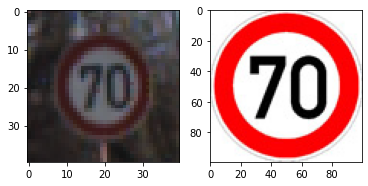

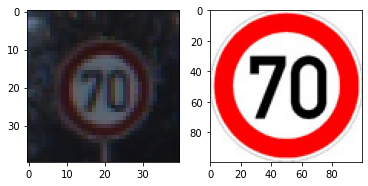

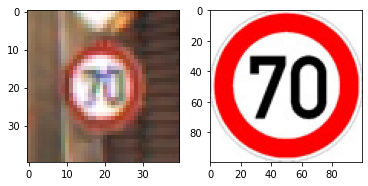

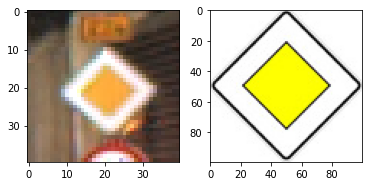

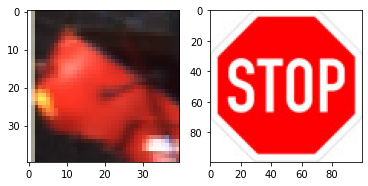

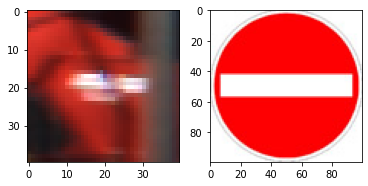

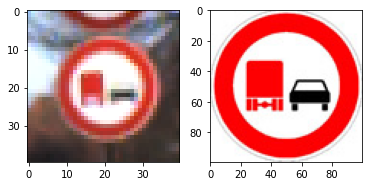

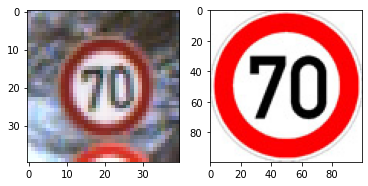

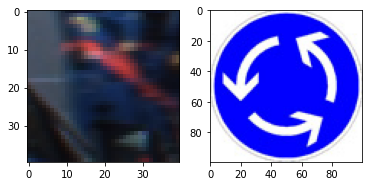

In [77]:
for i in range(20):
    pyplot.subplot(1,2,1)
    #extract actual image
    image = roi_images[i]
    image = np.float32(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pyplot.imshow(image)
    #find and show classification image
    for j in range(43):
        if preds[i,j] > 0.1:
            pyplot.subplot(1,2,2)
            pyplot.imshow(signs[j])
    pyplot.show()

## Add predicitons to input dataframes

Want to be able to check correctly and incorrectly found boxes, as well as see the classifications for what we found. 

In [79]:
#make array single column
preds_recode = pd.DataFrame(preds,columns = list(range(44))).idxmax(1)
#make pred df from boxes
preds_df = roi_df[roi_df['file_num']>599].reset_index(drop=True)
#add prediction column
preds_df['pred'] = preds_recode
preds_df.head()

,file,x1,y1,x2,y2,file_num,pred
0,00601.ppm,83,446,145,506,601,7
1,00601.ppm,1189,175,1216,194,601,43
2,00602.ppm,442,542,474,574,602,8
3,00602.ppm,1267,553,1301,586,602,8
4,00603.ppm,361,445,417,499,603,10


In [80]:
#make truth df
test_df = label_df[label_df['file_num']>599]
test_df.head()

,file,x1,y1,x2,y2,class,file_num
852,00601.ppm,82,450,145,508,7,601
853,00602.ppm,1268,555,1299,586,8,602
854,00602.ppm,443,543,474,574,8,602
855,00603.ppm,361,445,417,500,10,603
856,00604.ppm,365,482,437,546,30,604


If IoU > 0.4, correctly identified that a sign was there. This is for, there was a box and we found it

In [81]:
#Got the box right
found_sum = 0
rbox_df = pd.DataFrame()
#loop over images
for i in range(600,900):
    #get info for truth and pred for current file
    temp_test = test_df[test_df['file_num']==i]
    temp_roi = preds_df[preds_df['file_num']==i]
    #truth loop
    for j in range(temp_test.shape[0]):
        #make box for truth 
        box1 = [temp_test.iloc[j,1],temp_test.iloc[j,2],temp_test.iloc[j,3],temp_test.iloc[j,4]]
        box_found = 0
        #roi loop
        for k in range(temp_roi.shape[0]):
            #make box for pred
            box2 = [temp_roi.iloc[k,1],temp_roi.iloc[k,2],temp_roi.iloc[k,3],temp_roi.iloc[k,4]]
            #IoU
            iou = bb_intersection_over_union(box1,box2)
            #Enough overlap save
            if iou>0.4:
                box_found = 1
                rbox_df = pd.concat([rbox_df,pd.DataFrame({'file_num':[temp_test.iloc[j,6]],'iou':[iou],
                              'class':[temp_test.iloc[j,5]],'pred':[temp_roi.iloc[k,6]]})]) 
        found_sum += box_found
rbox_df.reset_index()
found_sum, test_df.shape[0],found_sum/test_df.shape[0]

(330, 361, 0.9141274238227147)

This checks the other end, how many false boxes were found, and how many weren't Background

In [ ]:
#Got the box wrong
found_sum = 0
wbox_df = pd.DataFrame()
count = 0
bad_list = []
#loop through images
for i in range(600,900):
    #that images df for actual and mine
    temp_test = test_df[test_df['file_num']==i]
    temp_roi = preds_df[preds_df['file_num']==i]
    #loop over rois
    for j in range(temp_roi.shape[0]):
        #box of roi
        box1 = [temp_roi.iloc[j,1],temp_roi.iloc[j,2],temp_roi.iloc[j,3],temp_roi.iloc[j,4]]
        box_found = 1
        #loop over true
        for k in range(temp_test.shape[0]):
            #box of truth and calculate iou
            box2 = [temp_test.iloc[k,1],temp_test.iloc[k,2],temp_test.iloc[k,3],temp_test.iloc[k,4]]
            iou = bb_intersection_over_union(box1,box2)
            if iou>0.4:
                #dont count because box was found
                box_found = 0
        if box_found == 1:
            wbox_df = pd.concat([wbox_df,pd.DataFrame({'file_num':[temp_roi.iloc[j,5]],
                              'pred':[temp_roi.iloc[j,6]]})])
            #not classified as bg
            if temp_roi.iloc[j,6] != 43:
                bad_list.append([count,temp_roi.iloc[j,6]])
        found_sum += box_found
        count += 1
wbox_df.reset_index()
found_sum, wbox_df[wbox_df['pred']!=43].shape[0],wbox_df[wbox_df['pred']!=43].shape[0]/found_sum

Look at what was found, and how it was classified. Can see some of the trends

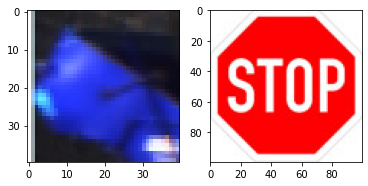

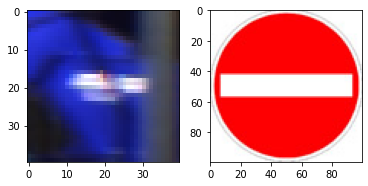

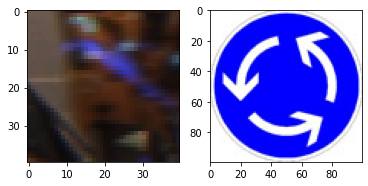

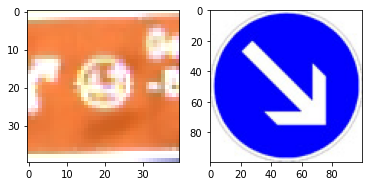

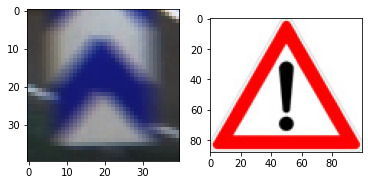

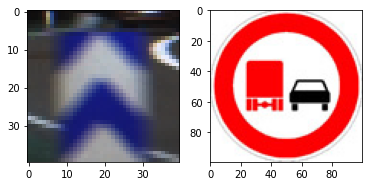

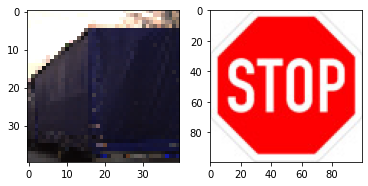

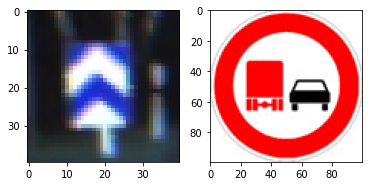

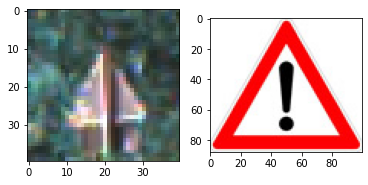

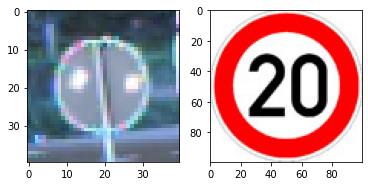

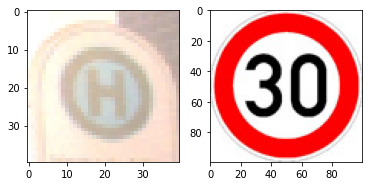

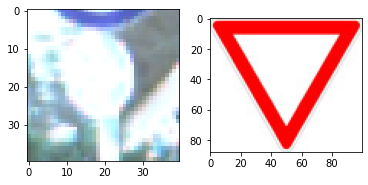

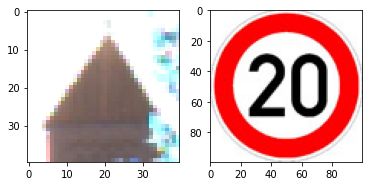

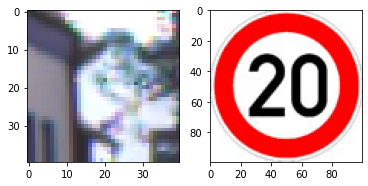

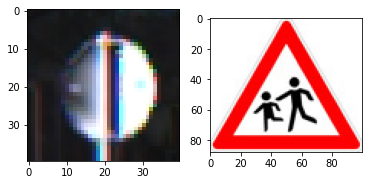

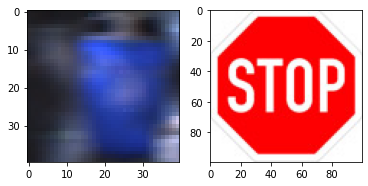

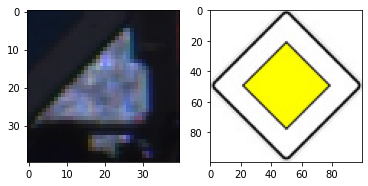

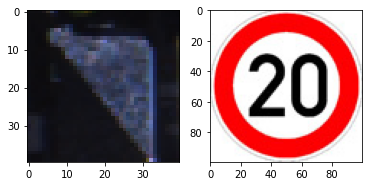

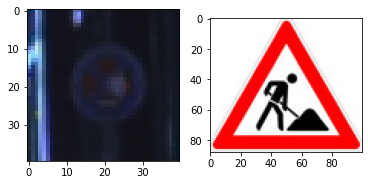

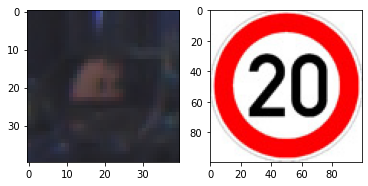

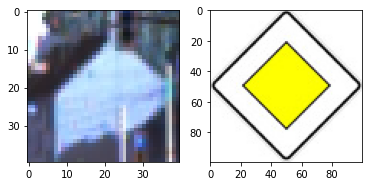

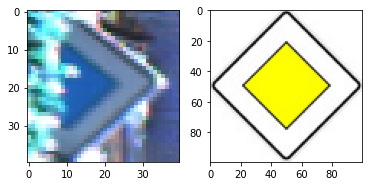

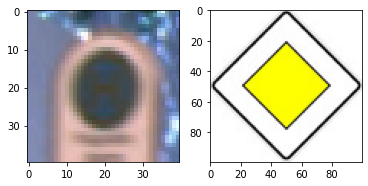

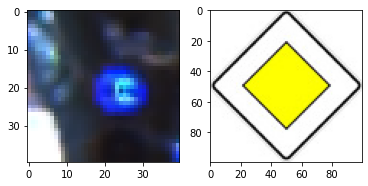

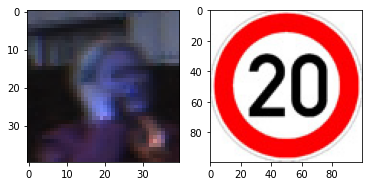

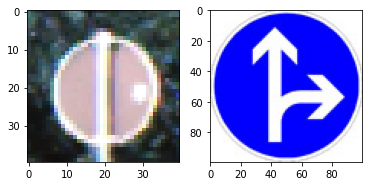

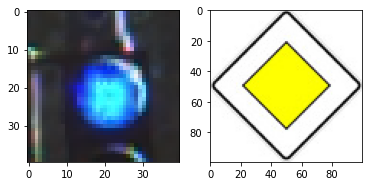

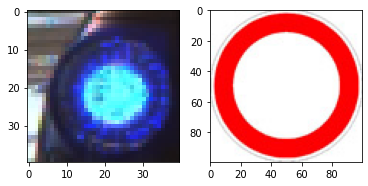

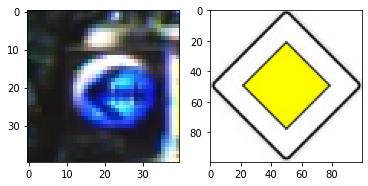

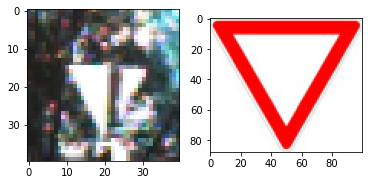

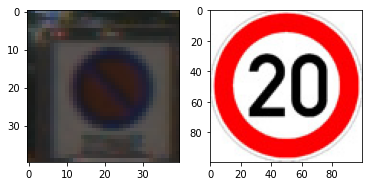

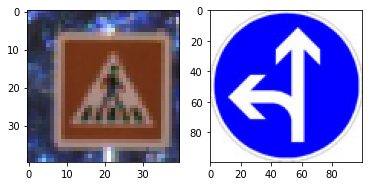

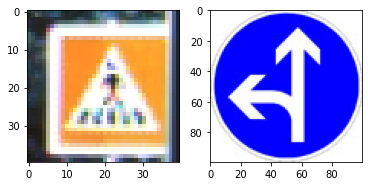

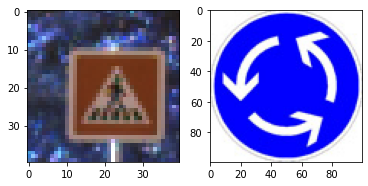

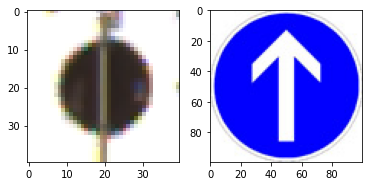

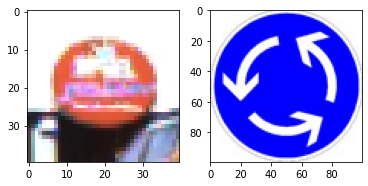

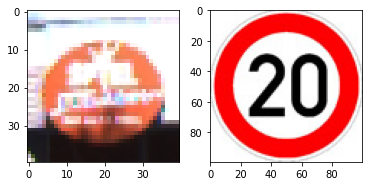

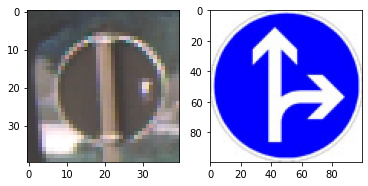

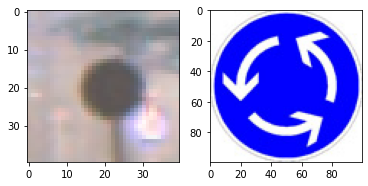

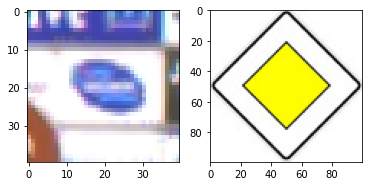

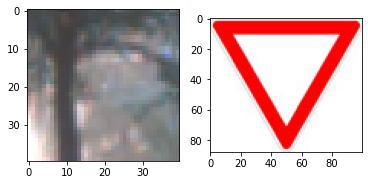

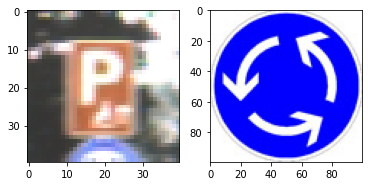

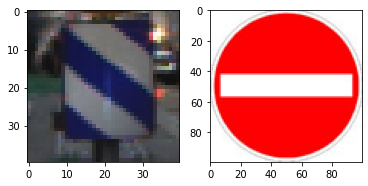

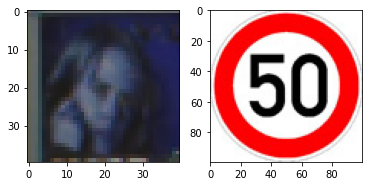

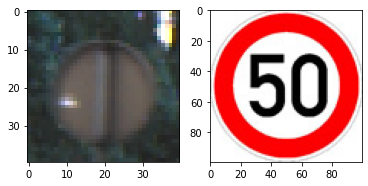

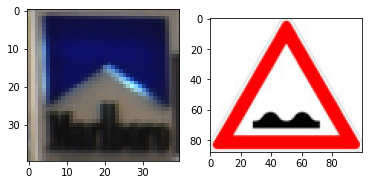

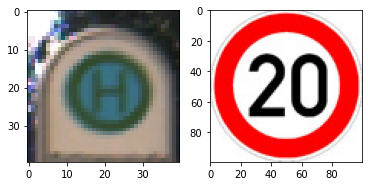

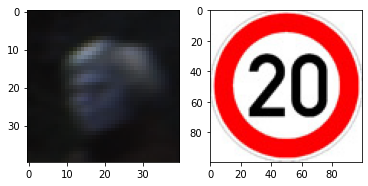

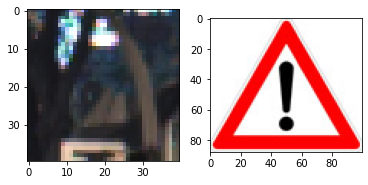

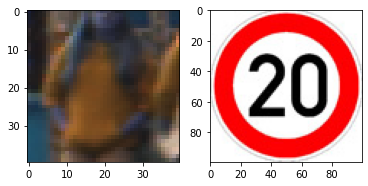

In [84]:
for i in range(50):
    #box that shouldn't be there
    pyplot.subplot(1,2,1)
    pyplot.imshow(roi_images[bad_list[i][0]])
    #what it thought it was
    pyplot.subplot(1,2,2)
    pyplot.imshow(signs[bad_list[i][1]])
    pyplot.show()

IoU for the truth and Masks

Text(0, 0.5, 'Counts')

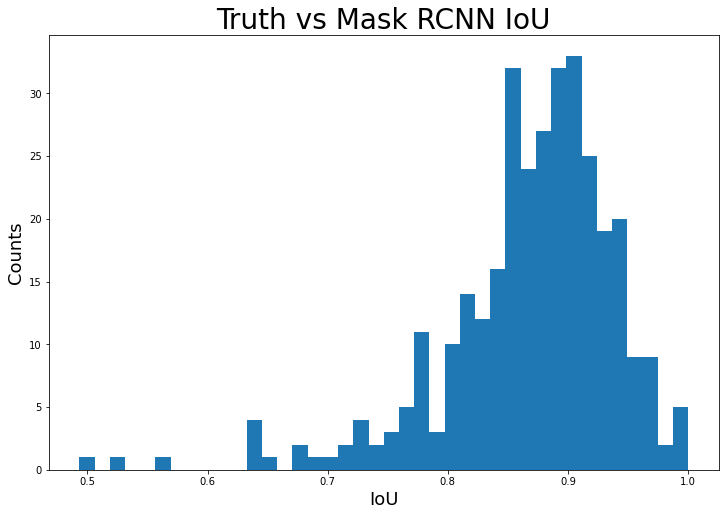

In [85]:
fig, ax = plt.subplots(figsize = (12,8))
plt.hist(rbox_df['iou'],bins=40);
ax.set_title('Truth vs Mask RCNN IoU',fontsize = 28)
ax.set_xlabel('IoU',fontsize= 18)
ax.set_ylabel('Counts',fontsize= 18)


In [86]:
rbox_df[rbox_df['class'] == rbox_df['pred']].shape[0]/rbox_df.shape[0]

0.9909365558912386